This notebook contains code and results for veracity prediction on Amazon reviews based on texts alone and texts with emotion features.

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import urllib.request
import zipfile

from keras import Input
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model, to_categorical
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
# Obtain final Amazon dataset.
data = pd.read_csv('../../data/results/amazon_final.csv')

In [21]:
# Define dimensionality of word embeddings.
embedding_dim = 300

# Define max input length.
max_seq_len = 500

In [22]:
# Encode emotion category.
data['PREDICTION'] = data['PREDICTION'].apply({'neutral':0, 'fear':1, 'sadness':2, 'joy':3,'anger':4}.get)
data

,REVIEW_TEXT,VERACITY,PREDICTION,joy,fear,neutral,anger,sadness
0,"When least you think so, this product will sav...",Fake,0,0.108776,0.035421,0.675116,0.196709,0.020431
1,Lithium batteries are something new introduced...,Fake,4,0.125708,0.103117,0.087749,0.627661,0.077903
2,I purchased this swing for my baby. She is 6 m...,Fake,0,0.261877,0.077076,0.413570,0.157695,0.113803
3,I was looking for an inexpensive desk calcolat...,Fake,1,0.107387,0.446936,0.163032,0.203908,0.093214
4,I m not sure what this is supposed to be but I...,Fake,0,0.229221,0.025874,0.672216,0.091756,0.014439
...,...,...,...,...,...,...,...,...
13980,These shoes are absolutely amazing. They are t...,Real,3,0.765827,0.011777,0.155121,0.068278,0.009005
13981,"My son had ordered it but when it arrived, he ...",Real,4,0.072390,0.062060,0.028264,0.771714,0.088904
13982,These shoes fit well. I purchased to wear to ...,Real,3,0.678554,0.028018,0.191851,0.054362,0.058558
13983,"These slippers are soft, warm, and very cozy. ...",Real,3,0.561892,0.037288,0.250742,0.157339,0.009371


In [50]:
# Leave 10% of data for test set, and split training test into training and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(data[['REVIEW_TEXT', 'PREDICTION', 'joy', 'fear', 'neutral', 'anger', 'sadness']], data.VERACITY, test_size=0.1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1)

In [51]:
# Obtain review texts for data and each data subset.
texts_train = X_train.REVIEW_TEXT.tolist()
texts_dev = X_dev.REVIEW_TEXT.tolist()
texts_test = X_test.REVIEW_TEXT.tolist()
texts = data.REVIEW_TEXT

In [69]:
# Fit tokenizer on review texts.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_dev = tokenizer.texts_to_sequences(texts_dev)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# Store the number of unique words (one added for padding).
vocab_size = len(index_of_words) + 1

Number of unique words: 24934


In [70]:
# Pad data.
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_dev_pad = pad_sequences(sequence_dev, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

In [55]:
# Encode veracity predictions.
encoding = {
    'Fake': 0,
    'Real': 1,
}

y_train = [encoding[y] for y in y_train]
y_dev = [encoding[y] for y in y_dev]
y_test = [encoding[y] for y in y_test]

In [56]:
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

In [57]:
def create_embedding_matrix(filepath, word_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [58]:
# Obtain wiki vectors.
fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('Done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [59]:
# Get embedding matrix.
embedding_matrix = create_embedding_matrix(fname, index_of_words, embedding_dim, vocab_size)
embedding_matrix.shape

(24935, 300)

In [60]:
# Obtain emotion categories.
X_emo_train = X_train[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values
X_emo_dev = X_dev[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values
X_emo_test = X_test[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values

In [77]:
# Define model input shapes.
input_text = Input(shape=(max_seq_len,))
input_emo = Input(shape=(6,))

### Obtain classification using text alone ###

In [104]:
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)(input_text)
cnn_layer = Conv1D(256, 3, activation='relu')(embedding_layer)
pool_layer = GlobalMaxPooling1D()(cnn_layer)
drop_layer = Dropout(.3)(pool_layer)
dense_layer = Dense(128, activation='relu')(drop_layer)
output = Dense(1, activation='sigmoid')(dense_layer)

In [105]:
model_text = Model(inputs=input_text, outputs=output)

In [106]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_text.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
print(model_text.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 300)          7480500   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129 

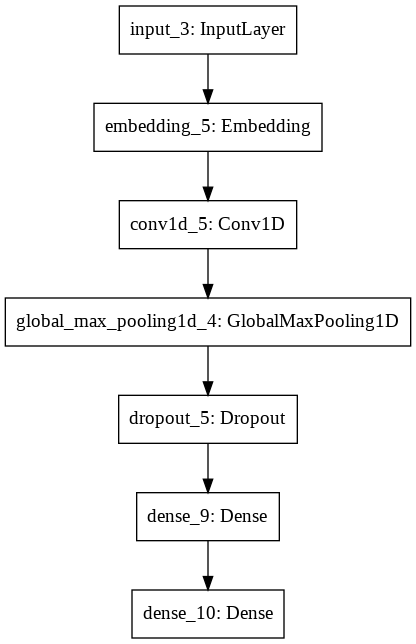

In [107]:
plot_model(model_text, to_file='model_plot_text.png')

In [108]:
# Define stopping criteria and fit model.
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model_text.fit(x=X_train_pad, 
                         y=y_train, 
                         batch_size=64, 
                         epochs=50, 
                         verbose=1,
                         validation_data=(X_dev_pad, y_dev), 
                         callbacks=[early_stopping_monitor])

Epoch 1/50
177/177 [==============================] - 112s 629ms/step - loss: 0.6969 - acc: 0.5036 - val_loss: 0.6818 - val_acc: 0.5782
Epoch 2/50
177/177 [==============================] - 111s 627ms/step - loss: 0.6799 - acc: 0.5694 - val_loss: 0.6680 - val_acc: 0.6060
Epoch 3/50
177/177 [==============================] - 113s 638ms/step - loss: 0.6667 - acc: 0.6063 - val_loss: 0.6555 - val_acc: 0.6116
Epoch 4/50
177/177 [==============================] - 109s 613ms/step - loss: 0.6487 - acc: 0.6283 - val_loss: 0.6555 - val_acc: 0.6029
Epoch 5/50
177/177 [==============================] - 110s 621ms/step - loss: 0.6375 - acc: 0.6417 - val_loss: 0.6340 - val_acc: 0.6394
Epoch 6/50
177/177 [==============================] - 110s 621ms/step - loss: 0.6206 - acc: 0.6624 - val_loss: 0.6243 - val_acc: 0.6473
Epoch 7/50
177/177 [==============================] - 108s 609ms/step - loss: 0.6001 - acc: 0.6896 - val_loss: 0.6171 - val_acc: 0.6458
Epoch 8/50
177/177 [============================

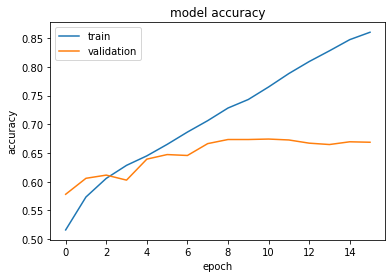

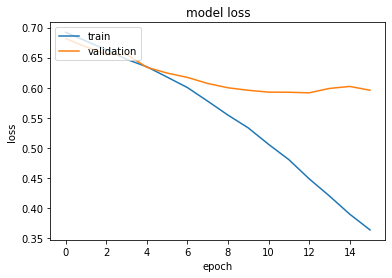

In [109]:
# Plot accuracy and loss of the model.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [127]:
# Obtain predictions and record key metrics.
predictions = model_text.predict(X_test_pad)

In [128]:
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

In [129]:
print('Classification report: ') 
print(classification_report(y_test, predictions, digits=4, target_names = ['Fake', 'Real']))

Classification report: 
              precision    recall  f1-score   support

        Fake     0.6895    0.7334    0.7108       754
        Real     0.6633    0.6140    0.6377       645

    accuracy                         0.6783      1399
   macro avg     0.6764    0.6737    0.6742      1399
weighted avg     0.6774    0.6783    0.6771      1399



Text(0.5, 1.0, 'Veracity Predictions on Texts Alone')

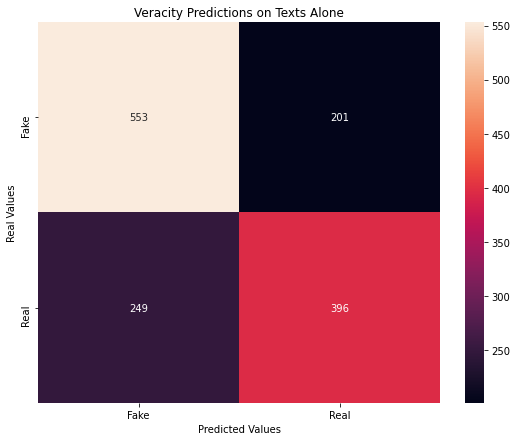

In [131]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [i for i in ['Fake', 'Real']],
                  columns = [i for i in ['Fake', 'Real']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('Veracity Predictions on Texts Alone')

In [124]:
# Save model for future use.
model_text.save('../../trained_models/veracity_text_only_cnn.h5')

### Obtain classification results on texts and emotion features ###

In [114]:
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)(input_text)
cnn_layer = Conv1D(256, 3, activation='relu')(embedding_layer)
pool_layer = GlobalMaxPooling1D()(cnn_layer)
drop_layer = Dropout(.3)(pool_layer)
concat_layer = Concatenate()([drop_layer, input_emo])
dense_layer = Dense(128, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer)

In [115]:
model_cnn = Model(inputs=[input_text, input_emo], outputs=output)

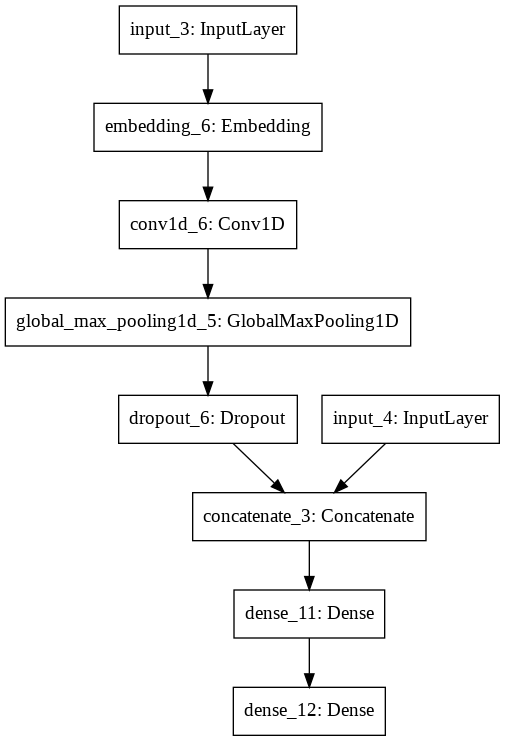

In [116]:
plot_model(model_cnn, to_file='model_plot.png')

In [117]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [118]:
# Define stopping criteria and train the model.
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model_cnn.fit(x=[X_train_pad, X_emo_train], 
                        y=y_train, 
                        batch_size=64, 
                        epochs=50, 
                        verbose=1, 
                        validation_data=([X_dev_pad, X_emo_dev], y_dev),
                        callbacks=[early_stopping_monitor])

Epoch 1/50
177/177 [==============================] - 110s 619ms/step - loss: 0.6892 - acc: 0.5414 - val_loss: 0.6762 - val_acc: 0.6013
Epoch 2/50
177/177 [==============================] - 108s 610ms/step - loss: 0.6787 - acc: 0.5711 - val_loss: 0.6616 - val_acc: 0.6291
Epoch 3/50
177/177 [==============================] - 111s 630ms/step - loss: 0.6604 - acc: 0.6100 - val_loss: 0.6523 - val_acc: 0.6187
Epoch 4/50
177/177 [==============================] - 109s 618ms/step - loss: 0.6450 - acc: 0.6311 - val_loss: 0.6390 - val_acc: 0.6442
Epoch 5/50
177/177 [==============================] - 109s 616ms/step - loss: 0.6258 - acc: 0.6576 - val_loss: 0.6296 - val_acc: 0.6553
Epoch 6/50
177/177 [==============================] - 107s 605ms/step - loss: 0.6160 - acc: 0.6636 - val_loss: 0.6233 - val_acc: 0.6394
Epoch 7/50
177/177 [==============================] - 110s 619ms/step - loss: 0.5939 - acc: 0.6895 - val_loss: 0.6121 - val_acc: 0.6656
Epoch 8/50
177/177 [============================

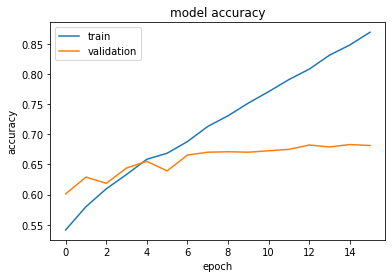

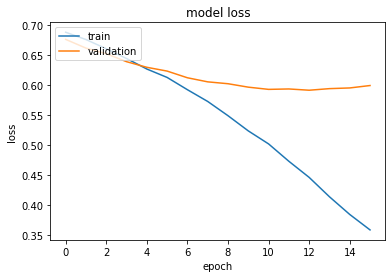

In [119]:
# Plot model accuracy and loss.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [120]:
# Make predictions and obtain key metrics.
predictions = model_cnn.predict([X_test_pad, X_emo_test])

In [121]:
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

In [122]:
print('Classification report: ') 
print(classification_report(y_test, predictions, digits=4, target_names = ['Fake', 'Real']))

Classification report: 
              precision    recall  f1-score   support

        Fake     0.7087    0.6936    0.7011       754
        Real     0.6505    0.6667    0.6585       645

    accuracy                         0.6812      1399
   macro avg     0.6796    0.6802    0.6798      1399
weighted avg     0.6819    0.6812    0.6814      1399



Text(0.5, 1.0, 'Veracity Predictions With Emotion Features')

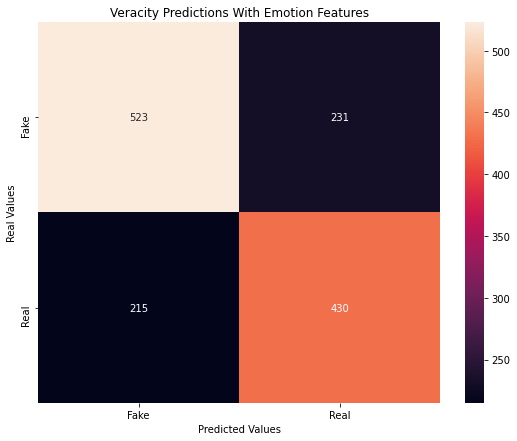

In [123]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [i for i in ['Fake', 'Real']],
                  columns = [i for i in ['Fake', 'Real']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('Veracity Predictions With Emotion Features')

In [126]:
# Store model for future use.
model_cnn.save('../../trained_models/veracity_text_emotions_cnn.h5')